# NCAR Innovator Program Project
### Notebook by: Maria J. Molina (NCAR/University of Maryland) and Jessica Moulite (Howard University)

Here we compare the NOAA KMIA weather station temperature data with 2-m temperature data from ERA5. The objective of the comparison is to assess how representative state-of-the-art reanalysis is of local weather and trends, given its heavy use in climate assessment studies.

Importing packages

In [1]:
import datetime
import warnings
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

Functions

In [2]:
def cel_to_far(tmp):
    """
    Convert celsius to farenheit
    """
    newtmp = []
    for i in tmp:
        if i == 99.9:
            newtmp.append(np.nan)
        if i != 99.9:
            newtmp.append((i * (9/5)) + 32)
    return np.array(newtmp)


def cel_to_nan(tmp):
    """
    Change 9999 to np.nan
    """
    newtmp = []
    for i in tmp:
        if i == 99.9:
            newtmp.append(np.nan)
        if i != 99.9:
            newtmp.append(i)
    return np.array(newtmp)


def convert_to_datetime(time_value):
    """
    Convert to a datetime object to be able to compute time difference.
    """
    return datetime.datetime(
        pd.to_datetime(time_value).year,
        pd.to_datetime(time_value).month,
        pd.to_datetime(time_value).day,
        pd.to_datetime(time_value).hour,
        pd.to_datetime(time_value).minute,
        pd.to_datetime(time_value).second,
    )


def compute_time_difference(a, b):
    """
    Compute time difference between two times.
    """
    if a >= b:
        return convert_to_datetime(a) - convert_to_datetime(b)
    if b > a:
        return convert_to_datetime(b) - convert_to_datetime(a)


def extract_era5_time(t_daily, t_full):
    """
    Extract the era5 temperature corresponding time.
    """
    era5_time_array = []

    for i, j in zip(t_daily.time, t_daily):

        tmp = t_full.sel(
            time=slice(i, pd.to_datetime(i.values) + datetime.timedelta(hours=23)))

        era5_time_array.append(tmp.where(tmp == j, drop=True).time.values)

    return era5_time_array


def ends(df, x=5):
    """
    Viewing the beginnings and ends.
    """
    return pd.concat([df.head(x),df.tail(x)])

## Open ERA5 data (1973-present)

In [3]:
# open files
ds_ = xr.open_mfdataset(
    '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/*/e5.oper.an.sfc.128_235_skt.ll025sc.*.nc'
)['SKT']

# time slice
ds_ = ds_.sel(time=slice('1973-01-01T00:00:00', '2022-08-01T23:00:00'))

In [4]:
ds_

<xarray.DataArray 'SKT' (time: 434640, latitude: 721, longitude: 1440)>
dask.array<getitem, shape=(434640, 721, 1440), dtype=float32, chunksize=(744, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1973-01-01 ... 2022-08-01T23:00:00
Attributes: (12/14)
    long_name:                                          Skin temperature
    short_name:                                         skt
    units:                                              K
    original_format:                                    WMO GRIB 1 with ECMWF...
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    235
    ...                                                 ...
    grid_specification:                                 0.25 degree x 0.25 de...
    rda_dataset:                                        ds633.0
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7

## Open NOAA KMIA station data

In [5]:
MIA_temp = pd.read_csv('/glade/scratch/molina/3043171.csv', low_memory=False)

In [6]:
# subset the data using dates of interest (what is available in ERA5)
MIA_temp = MIA_temp.iloc[:564195]

In [7]:
ends(MIA_temp, 2)

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,SOURCE,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,...,SA1,SLP,SOURCE.1,TMP,UA1,UG1,VIS,WA1,WG1,WND
0,72202012839,"MIAMI INTERNATIONAL AIRPORT, FL US",25.78810,-80.31690,8.8,1973-01-01T00:00:00,C,SY-SA,MIA,V020,...,NaN,"10177,5",C,"+0244,5",NaN,NaN,"016000,5,N,9",NaN,NaN,"090,5,N,0026,5"
1,72202012839,"MIAMI INTERNATIONAL AIRPORT, FL US",25.78810,-80.31690,8.8,1973-01-01T01:00:00,C,SAO,MIA,V020,...,NaN,"10182,5",C,"+0239,5",NaN,NaN,"016000,5,N,9",NaN,NaN,"090,5,N,0036,5"
564193,72202012839,"MIAMI INTERNATIONAL AIRPORT, FL US",25.78805,-80.31694,1.4,2022-08-01T22:53:00,6,FM-15,KMIA,V020,...,NaN,"10197,5",6,"+0300,5",NaN,NaN,"016093,5,N,5",NaN,NaN,"090,5,N,0046,5"
564194,72202012839,"MIAMI INTERNATIONAL AIRPORT, FL US",25.78805,-80.31694,1.4,2022-08-01T23:53:00,6,FM-15,KMIA,V020,...,NaN,"10196,5",6,"+0294,5",NaN,NaN,"016093,5,N,5",NaN,NaN,"100,5,N,0051,5"


In [8]:
time_date = []
temperature_C = []

for j, i in zip(MIA_temp['DATE'].values, MIA_temp['TMP'].values.astype(str)):

    time_date.append(j)

    # convert the string format to decimal format (originally in METAR code)
    temperature_C.append(
        float(i[0]+i.split(',')[0][2:-1]+'.'+i.split(',')[0][-1]))

time_date = np.array(time_date)
temperature_C = np.array(temperature_C)

temperature_F = cel_to_far(temperature_C)
temperature_C = cel_to_nan(temperature_C)

In [9]:
# making into dataframe for easier manipulation

# initialize data of lists.
data = {'Datetime': pd.to_datetime(time_date),
        'Temperature_C': temperature_C,
        'Temperature_F': temperature_F,
        'Latitude': MIA_temp['LATITUDE'],
        'Longitude': MIA_temp['LONGITUDE'],
       }

# Create DataFrame and quality control
df = pd.DataFrame(data)
#df = df.dropna()  # drop any nan values
df = df.drop_duplicates(keep='first')
# drop any duplicate rows
df = df[~df['Datetime'].duplicated()].drop_duplicates()

## Select temperatures from ERA5 using NOAA KMIA metadata (lat, lon, and hour)

In [10]:
with warnings.catch_warnings():

    warnings.simplefilter('ignore')

    tmp = ds_.sel(
        longitude=(df['Longitude'] % 360).unique()[-1], 
        latitude=df['Latitude'].unique()[-1], 
        method='nearest')

In [11]:
tmp

<xarray.DataArray 'SKT' (time: 434640)>
dask.array<getitem, shape=(434640,), dtype=float32, chunksize=(744,), chunktype=numpy.ndarray>
Coordinates:
    latitude   float64 25.75
    longitude  float64 279.8
  * time       (time) datetime64[ns] 1973-01-01 ... 2022-08-01T23:00:00
Attributes: (12/14)
    long_name:                                          Skin temperature
    short_name:                                         skt
    units:                                              K
    original_format:                                    WMO GRIB 1 with ECMWF...
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    235
    ...                                                 ...
    grid_specification:                                 0.25 degree x 0.25 de...
    rda_dataset:                                        ds633.0
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7

In [12]:
print('ERA5 coordinates:', tmp.latitude.values, tmp.longitude.values-360)
print('NOAA coordinates:', df['Latitude'].unique(), df['Longitude'].unique())

ERA5 coordinates: 25.75 -80.25
NOAA coordinates: [25.7881  25.7905  25.78805] [-80.3169  -80.3163  -80.31694]


In [13]:
ERA5_temperatures_C = (tmp - 273.15).values

ERA5_date = tmp.coords['time'].values

ERA5_temperatures_F = cel_to_far(ERA5_temperatures_C)

In [14]:
# initialize data of lists.
data = {'Datetime': pd.to_datetime(ERA5_date),
        'Temperature_C': ERA5_temperatures_C,
        'Temperature_F': ERA5_temperatures_F,
       }

df_era5 = pd.DataFrame(data)

### clean up dates prior to computation of metrics

In [15]:
df.isnull().sum()

Datetime             0
Temperature_C    40470
Temperature_F    40470
Latitude             0
Longitude            0
dtype: int64

In [16]:
df_era5.isnull().sum()

Datetime         0
Temperature_C    0
Temperature_F    0
dtype: int64

In [17]:
# confirm start and end dates are the same
assert df['Datetime'].iloc[0].date() == df_era5['Datetime'].iloc[0].date()
assert df['Datetime'].iloc[-1].date() == df_era5['Datetime'].iloc[-1].date()

## Create new variables

### Daily max and min temperatures

In [18]:
# Daily NOAA KMIA temperature maximum
tmax_NOAA_daily = df.set_index('Datetime').resample('1D').max()

In [19]:
tmax_NOAA_daily.isnull().sum()

Temperature_C    0
Temperature_F    0
Latitude         0
Longitude        0
dtype: int64

In [20]:
# Daily ERA5 temperature maximum
tmax_ERA5_daily = df_era5.set_index('Datetime').resample('1D').max()

In [21]:
tmax_ERA5_daily.isnull().sum()

Temperature_C    0
Temperature_F    0
dtype: int64

In [22]:
# Daily NOAA KMIA temperature minimum
tmin_NOAA_daily = df.set_index('Datetime').resample('1D').min()

In [23]:
tmin_NOAA_daily.isnull().sum()

Temperature_C    0
Temperature_F    0
Latitude         0
Longitude        0
dtype: int64

In [24]:
# Daily ERA5 temperature minimum
tmin_ERA5_daily = df_era5.set_index('Datetime').resample('1D').min()

In [25]:
tmin_ERA5_daily.isnull().sum()

Temperature_C    0
Temperature_F    0
dtype: int64

In [26]:
# double check array lengths
assert len(tmax_NOAA_daily) == len(tmax_ERA5_daily), 'Arrays not same length'
assert len(tmin_NOAA_daily) == len(tmin_ERA5_daily), 'Arrays not same length'

### Time of daily max and min temperatures

In [27]:
# corresponding date/time for NOAA KMIA daily temperature maximum
tmax_NOAA_daily_datetime = df.set_index('Datetime').resample('1D').agg(
    lambda x: np.nan if x.count() == 0 else x.idxmax()
)['Temperature_C']

In [28]:
tmax_NOAA_daily_datetime.isnull().sum()

0

In [29]:
# corresponding date/time for NOAA KMIA daily temperature minimum
tmin_NOAA_daily_datetime = df.set_index('Datetime').resample('1D').agg(
    lambda x: np.nan if x.count() == 0 else x.idxmin()
)['Temperature_C']

In [30]:
tmin_NOAA_daily_datetime.isnull().sum()

0

In [31]:
# corresponding date/time for ERA5 daily temperature maximum
tmax_ERA5_daily_datetime = df_era5.set_index('Datetime').resample('1D').agg(
    lambda x: np.nan if x.count() == 0 else x.idxmax()
)['Temperature_C']

In [32]:
tmax_ERA5_daily_datetime.isnull().sum()

0

In [33]:
# corresponding date/time for ERA5 daily temperature minimum
tmin_ERA5_daily_datetime = df_era5.set_index('Datetime').resample('1D').agg(
    lambda x: np.nan if x.count() == 0 else x.idxmin()
)['Temperature_C']

In [34]:
tmin_ERA5_daily_datetime.isnull().sum()

0

In [35]:
# double check array lengths
assert len(tmax_NOAA_daily_datetime) == len(tmax_ERA5_daily_datetime), 'Arrays not same length'
assert len(tmin_NOAA_daily_datetime) == len(tmin_ERA5_daily_datetime), 'Arrays not same length'

### Corresponding temperatures at the time of the max/min of other product

In [36]:
# the NOAA temperature during the (i.e., same time as the)
# daily ERA5 maximum temperature

NOAA_temp_during_ERA5_tmax_C = []
NOAA_temp_during_ERA5_tmax_F = []

for i in tmax_ERA5_daily_datetime.values:

    with warnings.catch_warnings():
        
        warnings.simplefilter('ignore')
    
        NOAA_temp_during_ERA5_tmax_C.append(
            df.iloc[df.set_index('Datetime').index.get_loc(i, method='nearest')]['Temperature_C'])

        NOAA_temp_during_ERA5_tmax_F.append(
            df.iloc[df.set_index('Datetime').index.get_loc(i, method='nearest')]['Temperature_F'])

NOAA_temp_during_ERA5_tmax_C = np.array(NOAA_temp_during_ERA5_tmax_C)
NOAA_temp_during_ERA5_tmax_F = np.array(NOAA_temp_during_ERA5_tmax_F)

In [37]:
print(np.any(np.isnan(NOAA_temp_during_ERA5_tmax_C)))
print(np.any(np.isnan(NOAA_temp_during_ERA5_tmax_F)))

True
True


In [38]:
# the NOAA temperature during the (i.e., same time as the)
# daily ERA5 minimum temperature

NOAA_temp_during_ERA5_tmin_C = []
NOAA_temp_during_ERA5_tmin_F = []

for i in tmin_ERA5_daily_datetime.values:

    with warnings.catch_warnings():
        
        warnings.simplefilter('ignore')
    
        NOAA_temp_during_ERA5_tmin_C.append(
            df.iloc[df.set_index('Datetime').index.get_loc(i, method='nearest')]['Temperature_C'])

        NOAA_temp_during_ERA5_tmin_F.append(
            df.iloc[df.set_index('Datetime').index.get_loc(i, method='nearest')]['Temperature_F'])

NOAA_temp_during_ERA5_tmin_C = np.array(NOAA_temp_during_ERA5_tmin_C)
NOAA_temp_during_ERA5_tmin_F = np.array(NOAA_temp_during_ERA5_tmin_F)

In [39]:
print(np.any(np.isnan(NOAA_temp_during_ERA5_tmin_C)))
print(np.any(np.isnan(NOAA_temp_during_ERA5_tmin_F)))

True
True


In [40]:
# the ERA5 temperature during the (i.e., same time as the)
# daily NOAA KMIA maximum temperature

ERA5_temp_during_NOAA_tmax_C = []
ERA5_temp_during_NOAA_tmax_F = []

for i in tmax_NOAA_daily_datetime.values:
    
    with warnings.catch_warnings():
        
        warnings.simplefilter('ignore')

        ERA5_temp_during_NOAA_tmax_C.append(
            df_era5.iloc[df_era5.set_index('Datetime').index.get_loc(
                i, method='nearest')]['Temperature_C'])

        ERA5_temp_during_NOAA_tmax_F.append(
            df_era5.iloc[df_era5.set_index('Datetime').index.get_loc(
                i, method='nearest')]['Temperature_F'])

ERA5_temp_during_NOAA_tmax_C = np.array(ERA5_temp_during_NOAA_tmax_C)
ERA5_temp_during_NOAA_tmax_F = np.array(ERA5_temp_during_NOAA_tmax_F)

In [41]:
print(np.any(np.isnan(ERA5_temp_during_NOAA_tmax_C)))
print(np.any(np.isnan(ERA5_temp_during_NOAA_tmax_F)))

False
False


In [42]:
# the ERA5 temperature during the (i.e., same time as the)
# daily NOAA minimum temperature

ERA5_temp_during_NOAA_tmin_C = []
ERA5_temp_during_NOAA_tmin_F = []

for i in tmin_NOAA_daily_datetime.values:

    with warnings.catch_warnings():
        
        warnings.simplefilter('ignore')

        ERA5_temp_during_NOAA_tmin_C.append(
            df_era5.iloc[df_era5.set_index('Datetime').index.get_loc(
                i, method='nearest')]['Temperature_C'])

        ERA5_temp_during_NOAA_tmin_F.append(
            df_era5.iloc[df_era5.set_index('Datetime').index.get_loc(
                i, method='nearest')]['Temperature_F'])

ERA5_temp_during_NOAA_tmin_C = np.array(ERA5_temp_during_NOAA_tmin_C)
ERA5_temp_during_NOAA_tmin_F = np.array(ERA5_temp_during_NOAA_tmin_F)

In [43]:
print(np.any(np.isnan(ERA5_temp_during_NOAA_tmin_C)))
print(np.any(np.isnan(ERA5_temp_during_NOAA_tmin_F)))

False
False


In [44]:
# double check array lengths
assert len(NOAA_temp_during_ERA5_tmax_C) == len(ERA5_temp_during_NOAA_tmax_C), 'Arrays not same length'
assert len(NOAA_temp_during_ERA5_tmin_C) == len(ERA5_temp_during_NOAA_tmin_C), 'Arrays not same length'
assert len(NOAA_temp_during_ERA5_tmax_F) == len(ERA5_temp_during_NOAA_tmax_F), 'Arrays not same length'
assert len(NOAA_temp_during_ERA5_tmin_F) == len(ERA5_temp_during_NOAA_tmin_F), 'Arrays not same length'

### differences (temperature)

In [45]:
# difference between NOAA KMIA temperature maximum and
# the ERA5 corresponding temperature at that time (C)
tmax_daily_difference_C = tmax_NOAA_daily['Temperature_C'] - ERA5_temp_during_NOAA_tmax_C

In [46]:
# difference between NOAA KMIA temperature maximum and
# the ERA5 corresponding temperature at that time (F)
tmax_daily_difference_F = tmax_NOAA_daily['Temperature_F'] - ERA5_temp_during_NOAA_tmax_F

In [47]:
# difference between NOAA KMIA temperature minimum and
# the ERA5 corresponding temperature at that time (C)
tmin_daily_difference_C = tmin_NOAA_daily['Temperature_C'] - ERA5_temp_during_NOAA_tmin_C

In [48]:
# difference between NOAA KMIA temperature minimum and
# the ERA5 corresponding temperature at that time (C)
tmin_daily_difference_F = tmin_NOAA_daily['Temperature_F'] - ERA5_temp_during_NOAA_tmin_F

### compute time differences

In [49]:
# absolute time difference between daily maximum temperature (ERA5 and NOAA KMIA)
tmax_diff = []
for i, j in zip(pd.to_datetime(tmax_NOAA_daily_datetime), tmax_ERA5_daily_datetime):
    tmax_diff.append(compute_time_difference(i, j))
tmax_diff = np.array(tmax_diff)

In [50]:
# absolute time difference between daily minimum temperature (ERA5 and NOAA KMIA)
tmin_diff = []
for i, j in zip(pd.to_datetime(tmin_NOAA_daily_datetime), tmin_ERA5_daily_datetime):
    tmin_diff.append(compute_time_difference(i, j))
tmin_diff = np.array(tmin_diff)

### create single csv file

In [51]:
data = {

    'NOAA_KMIA_Temperature_Daily_Max (C)': tmax_NOAA_daily['Temperature_C'],
    'NOAA_KMIA_Temperature_Daily_Max (F)': tmax_NOAA_daily['Temperature_F'],
    'NOAA_KMIA_Temperature_Daily_Max_Datetime': tmax_NOAA_daily_datetime,

    'NOAA_KMIA_Temperature_Daily_Min (C)': tmin_NOAA_daily['Temperature_C'],
    'NOAA_KMIA_Temperature_Daily_Min (F)': tmin_NOAA_daily['Temperature_F'],
    'NOAA_KMIA_Temperature_Daily_Min_Datetime': tmin_NOAA_daily_datetime,

    'ERA5_Temperature_Daily_Max (C)': tmax_ERA5_daily['Temperature_C'],
    'ERA5_Temperature_Daily_Max (F)': tmax_ERA5_daily['Temperature_F'],
    'ERA5_Temperature_Daily_Max_Datetime': tmax_ERA5_daily_datetime,

    'ERA5_Temperature_Daily_Min (C)': tmin_ERA5_daily['Temperature_C'],
    'ERA5_Temperature_Daily_Min (F)': tmin_ERA5_daily['Temperature_F'],
    'ERA5_Temperature_Daily_Min_Datetime': tmin_ERA5_daily_datetime,


    'ERA5_Corresponding_Temperature_During_NOAA_KMIA_Daily_Max (C)': ERA5_temp_during_NOAA_tmax_C,
    'ERA5_Corresponding_Temperature_During_NOAA_KMIA_Daily_Max (F)': ERA5_temp_during_NOAA_tmax_F,

    'ERA5_Corresponding_Temperature_During_NOAA_KMIA_Daily_Min (C)': ERA5_temp_during_NOAA_tmin_C,
    'ERA5_Corresponding_Temperature_During_NOAA_KMIA_Daily_Min (F)': ERA5_temp_during_NOAA_tmin_F,

    'NOAA_KMIA_Corresponding_Temperature_During_ERA5_Daily_Max (C)': NOAA_temp_during_ERA5_tmax_C,
    'NOAA_KMIA_Corresponding_Temperature_During_ERA5_Daily_Max (F)': NOAA_temp_during_ERA5_tmax_F,

    'NOAA_KMIA_Corresponding_Temperature_During_ERA5_Daily_Min (C)': NOAA_temp_during_ERA5_tmin_C,
    'NOAA_KMIA_Corresponding_Temperature_During_ERA5_Daily_Min (F)': NOAA_temp_during_ERA5_tmin_F,


    'Daily_Temperature_Max_Difference (C)': tmax_daily_difference_C.values,
    'Daily_Temperature_Max_Difference (F)': tmax_daily_difference_F.values,

    'Daily_Temperature_Min_Difference (C)': tmin_daily_difference_C.values,
    'Daily_Temperature_Min_Difference (F)': tmin_daily_difference_F.values,

    'Absolute_time_difference_tmax_ERA5_NOAA_KMIA (day H:M:S)': tmax_diff,
    'Absolute_time_difference_tmin_ERA5_NOAA_KMIA (day H:M:S)': tmin_diff,

       }

In [52]:
df_FINAL = pd.DataFrame(data)

In [53]:
ends(df_FINAL, 2)

,NOAA_KMIA_Temperature_Daily_Max (C),NOAA_KMIA_Temperature_Daily_Max (F),NOAA_KMIA_Temperature_Daily_Max_Datetime,NOAA_KMIA_Temperature_Daily_Min (C),NOAA_KMIA_Temperature_Daily_Min (F),NOAA_KMIA_Temperature_Daily_Min_Datetime,ERA5_Temperature_Daily_Max (C),ERA5_Temperature_Daily_Max (F),ERA5_Temperature_Daily_Max_Datetime,ERA5_Temperature_Daily_Min (C),...,NOAA_KMIA_Corresponding_Temperature_During_ERA5_Daily_Max (C),NOAA_KMIA_Corresponding_Temperature_During_ERA5_Daily_Max (F),NOAA_KMIA_Corresponding_Temperature_During_ERA5_Daily_Min (C),NOAA_KMIA_Corresponding_Temperature_During_ERA5_Daily_Min (F),Daily_Temperature_Max_Difference (C),Daily_Temperature_Max_Difference (F),Daily_Temperature_Min_Difference (C),Daily_Temperature_Min_Difference (F),Absolute_time_difference_tmax_ERA5_NOAA_KMIA (day H:M:S),Absolute_time_difference_tmin_ERA5_NOAA_KMIA (day H:M:S)
Datetime,,,,,,,,,,,,,,,,,,,,,
1973-01-01,26.7,80.06,1973-01-01 17:00:00,21.7,71.06,1973-01-01 12:00:00,28.108612,82.595502,1973-01-01 18:00:00,21.157379,...,26.7,80.06,22.2,71.96,-1.137921,-2.048258,0.297870,0.536166,0 days 01:00:00,0 days 01:00:00
1973-01-02,27.8,82.04,1973-01-02 18:00:00,21.1,69.98,1973-01-02 11:00:00,27.789581,82.021246,1973-01-02 17:00:00,22.280670,...,27.2,80.96,23.3,73.94,0.065961,0.118729,-1.271643,-2.288958,0 days 01:00:00,0 days 04:00:00
2022-07-31,32.8,91.04,2022-07-31 18:53:00,27.2,80.96,2022-07-31 09:53:00,33.562347,92.412225,2022-07-31 17:00:00,27.204193,...,32.2,89.96,27.2,80.96,-0.539233,-0.970620,-0.022443,-0.040397,0 days 01:53:00,0 days 01:07:00
2022-08-01,32.2,89.96,2022-08-01 16:53:00,27.2,80.96,2022-08-01 08:53:00,32.596436,90.673584,2022-08-01 17:00:00,26.767487,...,32.2,89.96,28.3,82.94,-0.396436,-0.713584,-0.252545,-0.454581,0 days 00:07:00,0 days 02:07:00


### data visualizations

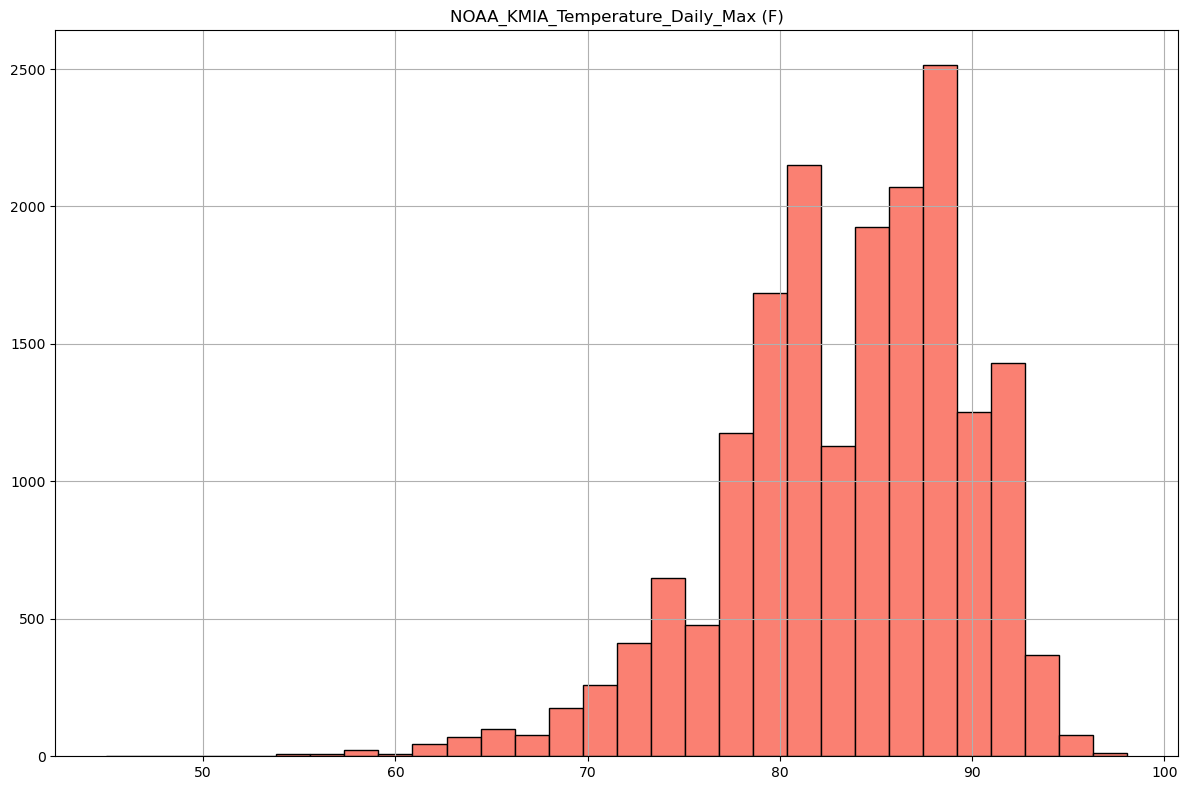

In [54]:
fig = df_FINAL.hist(
    'NOAA_KMIA_Temperature_Daily_Max (F)', edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
plt.show()

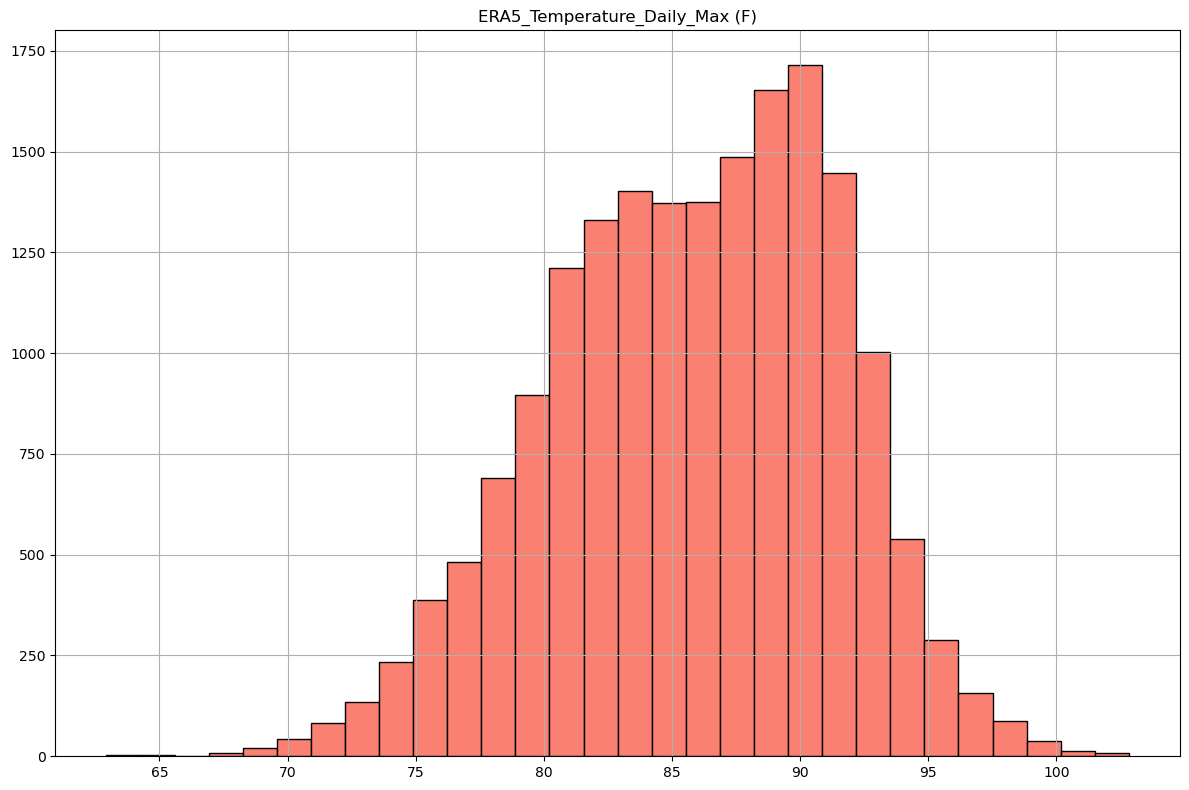

In [55]:
fig = df_FINAL.hist(
    'ERA5_Temperature_Daily_Max (F)', edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
plt.show()

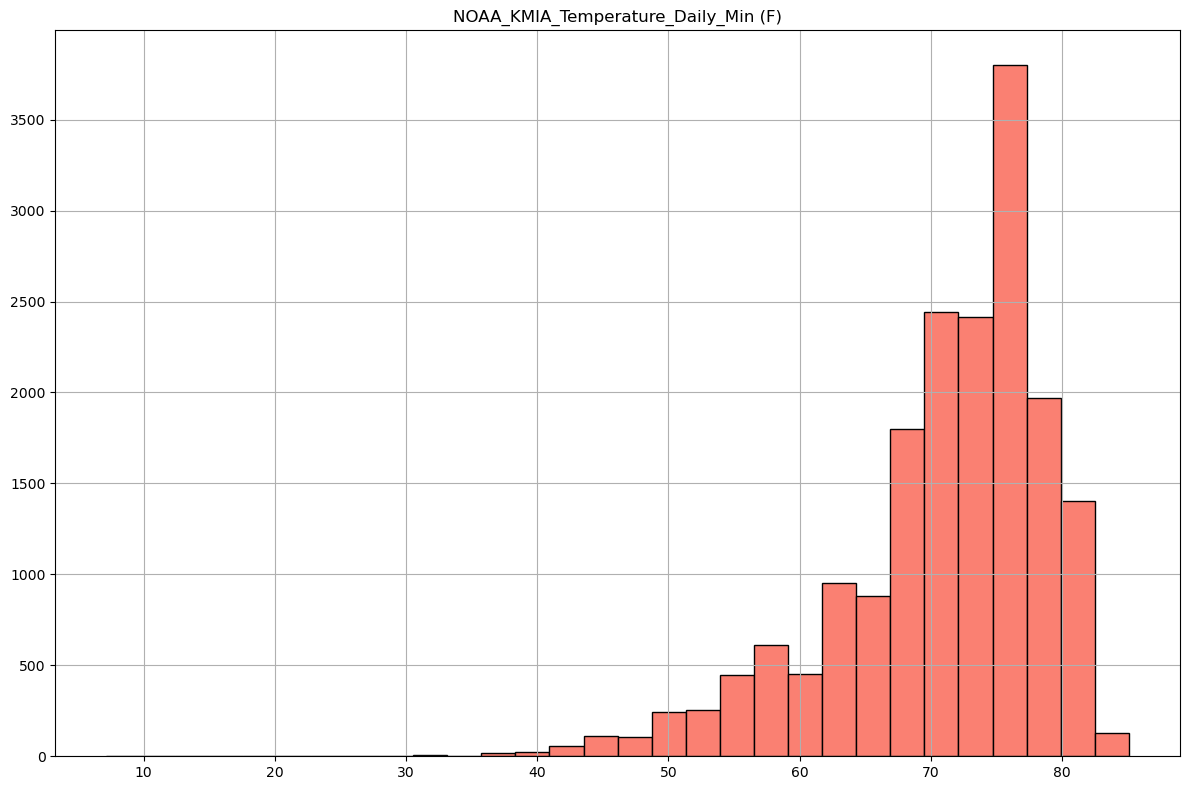

In [56]:
fig = df_FINAL.hist(
    'NOAA_KMIA_Temperature_Daily_Min (F)', edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
plt.show()

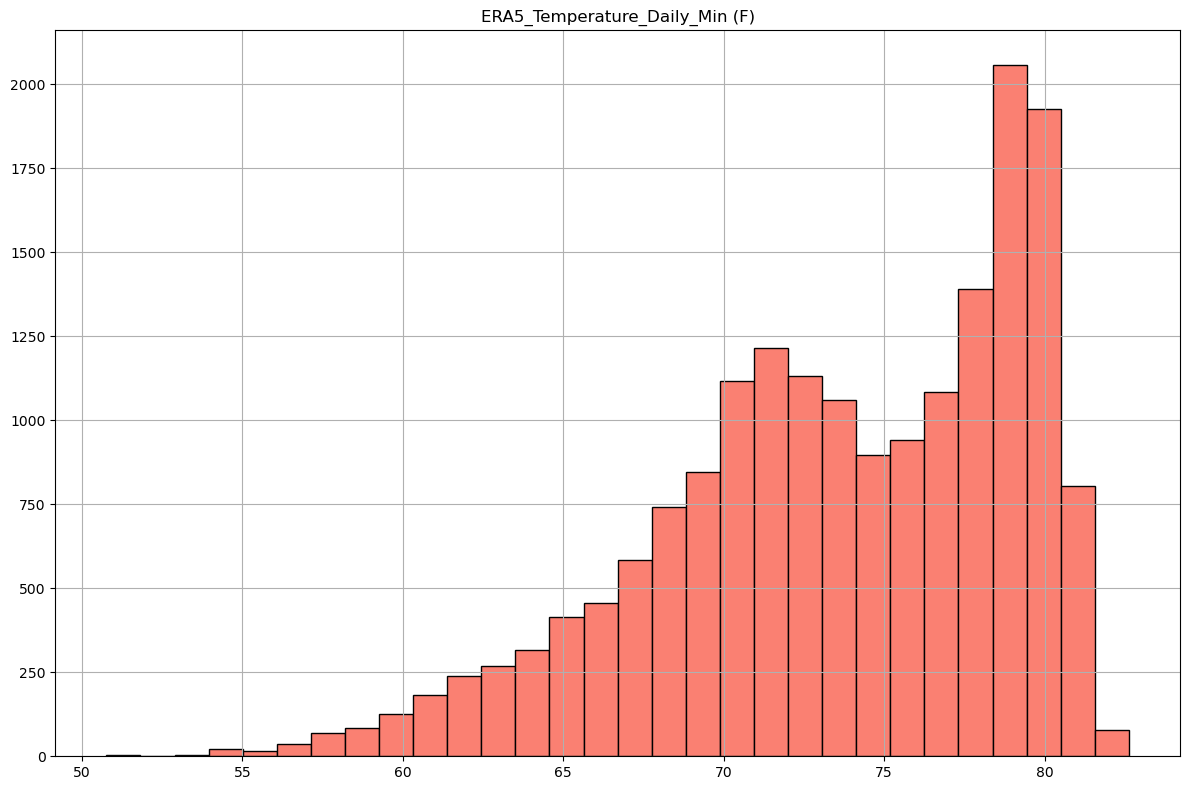

In [57]:
fig = df_FINAL.hist(
    'ERA5_Temperature_Daily_Min (F)', edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
plt.show()

## save csv file

In [3]:
df_FINAL.to_csv('/glade/scratch/molina/NOAA_KMIA_ERA5_SkinTemperature_1973-2022.csv')

In [4]:
import pandas as pd

In [5]:
df_FINAL = pd.read_csv(
    '/glade/scratch/molina/NOAA_KMIA_ERA5_SkinTemperature_1973-2022.csv')

In [6]:
df_FINAL.isnull().sum()

Datetime                                                           0
NOAA_KMIA_Temperature_Daily_Max (C)                                0
NOAA_KMIA_Temperature_Daily_Max (F)                                0
NOAA_KMIA_Temperature_Daily_Max_Datetime                           0
NOAA_KMIA_Temperature_Daily_Min (C)                                0
NOAA_KMIA_Temperature_Daily_Min (F)                                0
NOAA_KMIA_Temperature_Daily_Min_Datetime                           0
ERA5_Temperature_Daily_Max (C)                                     0
ERA5_Temperature_Daily_Max (F)                                     0
ERA5_Temperature_Daily_Max_Datetime                                0
ERA5_Temperature_Daily_Min (C)                                     0
ERA5_Temperature_Daily_Min (F)                                     0
ERA5_Temperature_Daily_Min_Datetime                                0
ERA5_Corresponding_Temperature_During_NOAA_KMIA_Daily_Max (C)      0
ERA5_Corresponding_Temperature_Dur

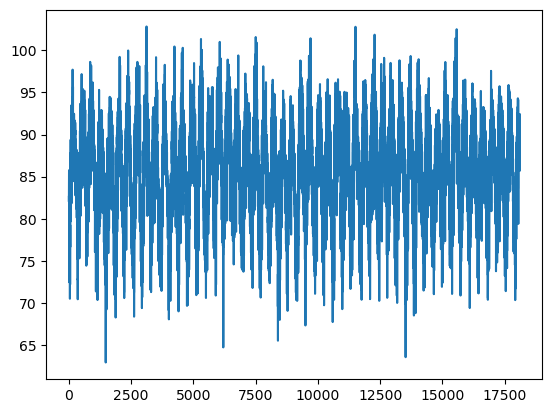

In [7]:
df_FINAL['ERA5_Temperature_Daily_Max (F)'].plot()

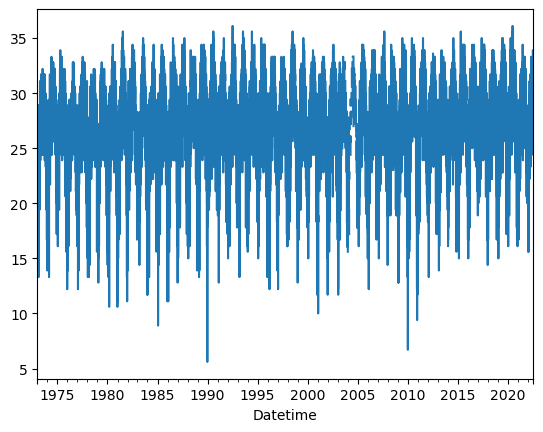

In [60]:
df_FINAL['NOAA_KMIA_Corresponding_Temperature_During_ERA5_Daily_Max (C)'].plot()

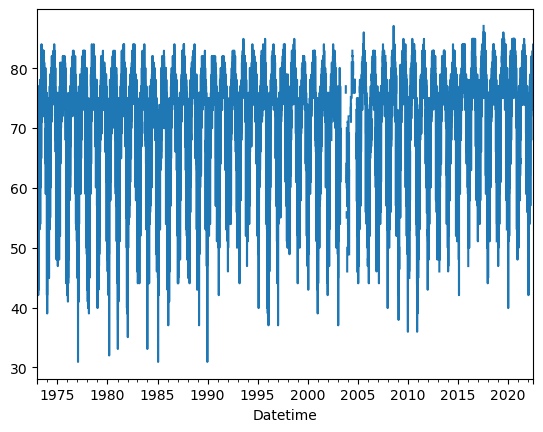

In [61]:
df_FINAL['NOAA_KMIA_Corresponding_Temperature_During_ERA5_Daily_Min (F)'].plot()

In [1]:
df_FINAL

NameError: name 'df_FINAL' is not defined